# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

37140


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc
import numpy as np

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')

Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2\figures.


## 1.2 setting up plotting parameters

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rc('font', family='serif')
plt.rc('font', serif='Arial')


# Other required plotting parameters
_dpi = 300
_font_size = 7.5
_page_width = 5.5

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})   

In [6]:
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]

celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}



# 2. Load codebook and chr2Zxys

## Codebook

Example of [codebook](../../postanalysis/0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [7]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_20230201\postanalysis_vCW2_sorted'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


# 3. Chromosome distribution of histone marks

## Load histone marks summary


 Data can be generated by the notebook:

 [0_locus_annotation/scripts/6_subclass_pairtags_means_by_loci_more_res](../0_locus_annotation/scripts/6_subclass_pairtags_means_by_loci_more_res.ipynb)

In [8]:
import tqdm

rna_summary_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v1\Nuclear_organization\analysis\analysis'

sel_class_list =celltype_palette.keys()


ref_measure_dict_byGroup = {}

for _class in tqdm.tqdm(sel_class_list):
    _class_name = _class.replace(' ','_').replace('/','_')
    #print(_class_name)
    rna_atac_fname = os.path.join(rna_summary_folder,f'subclass_{_class_name}_pairtag_mean_by_loci.csv')
    if os.path.exists(rna_atac_fname):
        rna_atac_df = pd.read_csv(rna_atac_fname,index_col=1)
        ref_measure_dict_byGroup[_class] = rna_atac_df

100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 190.46it/s]


In [9]:
ref_measure_dict_byGroup['L2/3 IT']

,Unnamed: 0,mean_H3K9me3_2X_2000kb,mean_H3K27me3_2X_2000kb,mean_H3K27ac_2X_2000kb,mean_H3K4me3_2X_2000kb
loci_name,,,,,
chr1_3742742_3759944,0,3.596887,0.717670,1.176722,0.0
chr1_6245958_6258969,1,6.527626,1.332675,1.262035,0.0
chr1_8740008_8759916,2,5.540078,1.168806,1.879951,0.0
chr1_9627926_9637875,3,5.129961,0.919052,1.827544,0.0
chr1_9799472_9811359,4,4.866926,0.908193,1.826935,0.0
...,...,...,...,...,...
chrX_166247682_166259932,1977,2.461479,0.708786,2.070689,0.0
chrX_167157164_167167452,1978,2.506615,0.649556,2.068251,0.0
chrX_168746045_168757590,1979,1.870039,0.467917,1.492992,0.0


In [10]:
ref_measure_dict_byGroup['L4/5 IT']

,Unnamed: 0,mean_H3K9me3_2X_2000kb,mean_H3K27me3_2X_2000kb,mean_H3K27ac_2X_2000kb,mean_H3K4me3_2X_2000kb
loci_name,,,,,
chr1_3742742_3759944,0,2.271961,0.503195,1.086957,0.086957
chr1_6245958_6258969,1,4.150421,0.929712,1.092754,0.347826
chr1_8740008_8759916,2,3.878460,0.650160,1.438647,0.434783
chr1_9627926_9637875,3,3.486161,0.482428,1.414493,0.347826
chr1_9799472_9811359,4,3.268351,0.456869,1.413527,0.347826
...,...,...,...,...,...
chrX_166247682_166259932,1977,1.606498,0.509585,1.640580,0.217391
chrX_167157164_167167452,1978,1.630566,0.496805,1.543961,0.173913
chrX_168746045_168757590,1979,1.206980,0.439297,1.159420,0.130435


# 4. Load summarized radial position

Data can be generated by the notebook

[1_radial_position_convexhull_singlecell_dataframe](1_radial_position_convexhull_singlecell_dataframe.ipynb)

In [11]:
min_pts_th = 600
output_fname = os.path.join(output_analysis_folder, f'radial_pos_convexhull_median_summary_{min_pts_th}pts_bysubclass_v2.csv')

sorted_median_radial_pos_all = pd.read_csv(output_fname, index_col=0)
sorted_median_radial_pos_all.head()

,chr,chr_order,norm_radial_position,total_cell,subclass
loci_name,,,,,
chr1_3742742_3759944,1,0,0.860136,1022.0,L2/3 IT
chr1_6245958_6258969,1,1,0.855358,969.0,L2/3 IT
chr1_8740008_8759916,1,2,0.850017,628.0,L2/3 IT
chr1_9627926_9637875,1,3,0.839728,960.0,L2/3 IT
chr1_9799472_9811359,1,4,0.826204,900.0,L2/3 IT


# 5. Load RNA and ATAC 


 Data can be generated by the notebook:

 [0_locus_annotation/scripts/4_subclass_atac_and_rna_means_by_loci](../0_locus_annotation/scripts/4_subclass_atac_and_rna_means_by_loci.ipynb)

In [12]:
import tqdm

rna_summary_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v1\AB_compartment\analysis'

sel_class_list =celltype_palette.keys()


ref_measure_dict_byGroup_rna = {}

for _class in tqdm.tqdm(sel_class_list):
    _class_name = _class.replace(' ','_').replace('/','_')
    #print(_class_name)
    rna_atac_fname = os.path.join(rna_summary_folder,f'subclass_{_class_name}_snATAC_snRNA_mean_by_loci.csv')
    if os.path.exists(rna_atac_fname):
        rna_atac_df = pd.read_csv(rna_atac_fname,index_col=1)
        ref_measure_dict_byGroup_rna[_class] = rna_atac_df

100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 199.76it/s]


In [13]:
rna_atac_df.head()
#len(rna_atac_df)

,Unnamed: 0,mean_rna_2X_2000kb,mean_rna_2X_200kb,mean_rna_2X_50kb
loci_name,,,,
chr1_3742742_3759944,0,14.736264,12.552198,0.000000
chr1_6245958_6258969,1,5.254579,1.544872,1.544872
chr1_8740008_8759916,2,28.511905,0.000000,0.000000
chr1_9627926_9637875,3,33.426740,0.657509,0.000000
chr1_9799472_9811359,4,33.426740,0.854396,0.163004


# 6. Convert to summary df

In [14]:
#rna_summary_df = pd.DataFrame(index = rna_df_dict['L2/3 IT'].index)

target_mode_list = ['H3K9me3','H3K27me3','H3K27ac','H3K4me3',]
rna_mode_list = ['rna','ATAC']

rna_summary_dict = {'H3K9me3':[],'H3K27me3':[],'H3K27ac':[],'H3K4me3':[], 'rna':[], 'ATAC':[], 
                    'loci':[],'celltype':[],'chr':[],'norm_radial_position':[],'total_cell':[],}
for _group, _rna_df in ref_measure_dict_byGroup.items():
    #rna_summary_dict['rna'].extend(_rna_df['log10p_mean_rna'].tolist())
    #rna_summary_dict['rna'].extend(_rna_df['mean_rna'].tolist())
    for target_mode in target_mode_list:
        if f'mean_{target_mode}_2X_2000kb' in _rna_df.columns:
            rna_summary_dict[target_mode].extend(_rna_df[f'mean_{target_mode}_2X_2000kb'].tolist())
        else:
            rna_summary_dict[target_mode].extend([np.nan]*len(_rna_df))
            
    for rna_mode in rna_mode_list:
        if _group in ref_measure_dict_byGroup_rna.keys():
            _rna_df_2 = ref_measure_dict_byGroup_rna[_group]
            if f'mean_{rna_mode}_2X_2000kb' in _rna_df_2.columns:
                rna_summary_dict[rna_mode].extend(_rna_df_2[f'mean_{rna_mode}_2X_2000kb'].tolist())
            else:
                rna_summary_dict[rna_mode].extend([np.nan]*len(_rna_df))
        else:
            rna_summary_dict[rna_mode].extend([np.nan]*len(_rna_df))
                
    rna_summary_dict['loci'].extend(_rna_df.index.tolist())
    rna_summary_dict['celltype'].extend([_group]*len(_rna_df))
    rna_summary_dict['chr'].extend([i.split('_')[0] for i in _rna_df.index.tolist()])
    
    group_radial_pos_all = sorted_median_radial_pos_all[sorted_median_radial_pos_all['subclass']==_group]
    if len(group_radial_pos_all)==len(_rna_df):
        group_radial_pos_all = group_radial_pos_all.loc[_rna_df.index]
        radial_pos_list = group_radial_pos_all['norm_radial_position'].tolist()
        radial_N_list = group_radial_pos_all['total_cell'].tolist()
    else:
        radial_pos_list = [np.nan]*len(_rna_df)
        radial_N_list = [np.nan]*len(_rna_df)
        
    rna_summary_dict['norm_radial_position'].extend(radial_pos_list)
    rna_summary_dict['total_cell'].extend(radial_N_list)
    
    
rna_summary_df = pd.DataFrame(rna_summary_dict)
rna_summary_df

,H3K9me3,H3K27me3,H3K27ac,H3K4me3,rna,ATAC,loci,celltype,chr,norm_radial_position,total_cell
0,2.528736,0.571429,0.739910,0.332378,9.202454,1.459956,chr1_3742742_3759944,Astro,chr1,0.831239,1020.0
1,3.731801,0.688312,1.001495,0.491404,11.447853,1.840378,chr1_6245958_6258969,Astro,chr1,0.785055,807.0
2,3.189655,0.370130,1.028401,0.451289,6.288344,1.721496,chr1_8740008_8759916,Astro,chr1,0.836495,563.0
3,3.017241,0.441558,1.678625,0.464183,13.969325,2.377364,chr1_9627926_9637875,Astro,chr1,0.764242,826.0
4,3.040230,0.428571,1.686099,0.465616,13.969325,2.404199,chr1_9799472_9811359,Astro,chr1,0.750467,770.0
...,...,...,...,...,...,...,...,...,...,...,...
29725,3.069597,0.398438,2.511182,0.542373,4.638298,3.894289,chrX_166247682_166259932,Sst,chrX,0.812094,127.0
29726,3.304029,0.460938,2.523962,0.576271,30.595154,3.993115,chrX_167157164_167167452,Sst,chrX,0.786706,140.0
29727,2.421245,0.429688,2.019169,0.406780,28.309693,3.512353,chrX_168746045_168757590,Sst,chrX,0.777460,127.0
29728,1.772894,0.281250,1.009585,0.169492,27.760047,1.829081,chrX_169963295_170005197,Sst,chrX,0.782206,192.0


# 7. Visualize chromosomes

## H3K9me3

In [21]:
AB_palette = {'non-repressive':'orange','repressive':'blue',
              #'intermediate':'gray'
             }

meta NOT subset; don't know how to subset; dropped


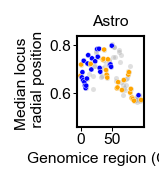

meta NOT subset; don't know how to subset; dropped


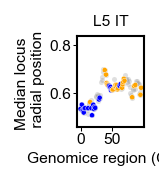

In [22]:
%matplotlib inline
select_chroms_plot = [str(i) for i in range(1,20)]
select_chroms_plot.append('X')
select_chroms_plot = [c for c in select_chroms_plot if c in ['9','11','7','17',]]
select_chroms_plot = ['7',]

target_mode_list = ['H3K9me3',
                   ]

#sel_mode = 'H3K9me3'

for sel_chrom in select_chroms_plot:
    for _group_idx, _group in enumerate(['Astro', 'L5 IT']):
        
        for sel_mode in target_mode_list:
            plot_df = rna_summary_df[rna_summary_df['chr']==f'chr{sel_chrom}']
            plot_df = plot_df[plot_df['celltype']==_group]

            sel_mode_h = np.percentile(plot_df[f'{sel_mode}'],75)
            sel_mode_l = np.percentile(plot_df[f'{sel_mode}'],25)
            plot_df.loc[plot_df[f'{sel_mode}']> sel_mode_h,f'{sel_mode}_type']='repressive'
            plot_df.loc[plot_df[f'{sel_mode}']< sel_mode_l,f'{sel_mode}_type']='non-repressive'
            #plot_df.loc[(plot_df[f'{sel_mode}']<= sel_mode_h)&(plot_df[f'{sel_mode}']>= sel_mode_l)
                                #,f'{sel_mode}_type']='intermediate'

            fig,ax=plt.subplots(figsize=(_page_width/6/1.6,_page_width/7),dpi=150)

            
            gfg = sns.scatterplot(data=plot_df,s=6,
                                  x=np.arange(0,len(plot_df)), y='norm_radial_position',
                                  color='gray',alpha=0.25, 
                                  #order = selected_cell_labels, 
                                  #hue=f'{sel_mode}_type', #hue_order=['high','low'], palette=AB_palette,
                                  ax=ax,
                                 )
            
            
            gfg = sns.scatterplot(data=plot_df, x=np.arange(0,len(plot_df)), y='norm_radial_position',
                              #order = selected_cell_labels, 
                              hue=f'{sel_mode}_type', hue_order=['non-repressive','repressive'], palette=AB_palette,
                              ax=ax,s=6,legend=False,
                             )
            
            ax.set_title(f'{_group}',fontsize=_font_size, pad=5)
            ax.grid(False)
            ax.tick_params('x', labelsize=_font_size, 
                        width=_ticklabel_width, length=_ticklabel_size,
                        pad=1, labelbottom=True) # remove bottom ticklabels for _ax
            ax.tick_params('y', labelsize=_font_size, 
                            width=_ticklabel_width, length=_ticklabel_size,
                            pad=1, labelleft=True)
            ax.set_ylabel('Median locus \n radial position',fontsize=_font_size,labelpad=2)
            ax.set_xlabel(f'Genomice region (Chr{sel_chrom})', fontsize=_font_size, labelpad=2)
            #ax.hlines(0.63,0, len(plot_df))
            plt.ylim([0.46, 0.84])
            
            plt.savefig(os.path.join(output_figure_folder, f'Radial_{sel_chrom}_color_by_{sel_mode}_{_group}.pdf'), 
                transparent=True, dpi=300, bbox_inches='tight') 

        plt.show()

## ATAC

In [24]:
AB_palette = {'open':'orange','closed':'blue',
              #'intermediate':'gray'
             }

meta NOT subset; don't know how to subset; dropped


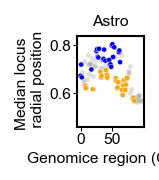

meta NOT subset; don't know how to subset; dropped


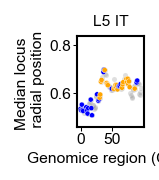

In [25]:
%matplotlib inline
select_chroms_plot = [str(i) for i in range(1,20)]
select_chroms_plot.append('X')
select_chroms_plot = [c for c in select_chroms_plot if c in ['9','11','7','17',]]
select_chroms_plot = ['7',]

target_mode_list = ['ATAC',
                   ]

#sel_mode = 'H3K9me3'

for sel_chrom in select_chroms_plot:
    for _group_idx, _group in enumerate(['Astro', 'L5 IT']):
        
        for sel_mode in target_mode_list:
            plot_df = rna_summary_df[rna_summary_df['chr']==f'chr{sel_chrom}']
            plot_df = plot_df[plot_df['celltype']==_group]

            sel_mode_h = np.percentile(plot_df[f'{sel_mode}'],75)
            sel_mode_l = np.percentile(plot_df[f'{sel_mode}'],25)
            plot_df.loc[plot_df[f'{sel_mode}']> sel_mode_h,f'{sel_mode}_type']='open'
            plot_df.loc[plot_df[f'{sel_mode}']< sel_mode_l,f'{sel_mode}_type']='closed'
            #plot_df.loc[(plot_df[f'{sel_mode}']<= sel_mode_h)&(plot_df[f'{sel_mode}']>= sel_mode_l)
                                #,f'{sel_mode}_type']='intermediate'

            fig,ax=plt.subplots(figsize=(_page_width/6/1.6,_page_width/7),dpi=150)

            
            gfg = sns.scatterplot(data=plot_df,s=6,
                                  x=np.arange(0,len(plot_df)), y='norm_radial_position',
                                  color='gray',alpha=0.25, 
                                  #order = selected_cell_labels, 
                                  #hue=f'{sel_mode}_type', #hue_order=['high','low'], palette=AB_palette,
                                  ax=ax,legend=False,
                                 )
            
            gfg = sns.scatterplot(data=plot_df, x=np.arange(0,len(plot_df)), y='norm_radial_position',
                              #order = selected_cell_labels, 
                              hue=f'{sel_mode}_type', #hue_order=['yes','no'],
                                palette=AB_palette,legend=False,
                              ax=ax,s=6,
                             )


            
            ax.set_title(f'{_group}',fontsize=_font_size, pad=5)
            ax.grid(False)
            ax.tick_params('x', labelsize=_font_size, 
                        width=_ticklabel_width, length=_ticklabel_size,
                        pad=1, labelbottom=True) # remove bottom ticklabels for _ax
            ax.tick_params('y', labelsize=_font_size, 
                            width=_ticklabel_width, length=_ticklabel_size,
                            pad=1, labelleft=True)
            ax.set_ylabel('Median locus \n radial position',fontsize=_font_size,labelpad=2)
            ax.set_xlabel(f'Genomice region (Chr{sel_chrom})', fontsize=_font_size, labelpad=2)
            #ax.hlines(0.63,0, len(plot_df))

          
            plt.ylim([0.46, 0.84])
            
            plt.savefig(os.path.join(output_figure_folder, f'Radial_{sel_chrom}_color_by_{sel_mode}_{_group}.pdf'), 
                transparent=True, dpi=300, bbox_inches='tight') 

        plt.show()